# Accelerated Imaging Methods

MRI scans can be accelerated by applying methods that reduce the number of k-space samples required, also known as undersampling.  These require a corresponding advanced image reconstruction method to allow for the reduced sampling.  The techniques covered here include partial Fourier reconstruction, parallel imaging, compressed sensing, and deep learning methods. 

## Learning Goals

1. Describe how images are formed
    * Describe how accelerated imaging methods work
1. Understand the constraints and tradeoffs in MRI
    * Identify accelerated imaging methods
    * Understand when accelerated imaging methods can be applied
1. Manipulate MRI sequence parameters to improve performance
    * Define which parameters are modified when accelerated imaging methods are applied
1. Manipulate and analyze MRI data
    * Reconstruct an image from undersampled raw data


## General Principles

Accelerated Imaging in MRI are methods that reduce the number of k-space samples required.
Since this violates our sampling criteria (Nyquist) this is often referred to as “undersampling.”
This allows for shorter scan times, which can be used to incease throughput, reduce artifacts, acquire more contrasts, and/or improve spatial resolution. 

All of these methods require additional steps in image reconstruction beyond using a Fourier Transform.  These steps are based on the assumptions and a model for the accelerated imaging method being used.

## Methods Inventory and Comparison


| Method | Assumptions | Methods | Pros | Cons |
|---|---|---|---|---|
| Partial Fourier | Transverse magnetization phase is slowly varying across the image | Skip almost one side of k-space; Estimate phase with center of k-space | Can be used in many circumstances; Reduce phase encodes or frequency encoding readout length | Should not be used when phase contrast is important |
| Parallel Imaging | RF receive coil arrays provide spatial encoding information | Skip phase encoding lines and/or simultaneous multi-slice excitation; Measure or model RF coil sensitivities and incorporate in reconstruction| Can be used with all pulse sequences | Geometry “g-factor” SNR losses |
| Compressed Sensing | Data is compressible and has a sparse representation | Pseudo-random skip of phase encoding lines; Solve optimization problem in reconstruction| Can be used with all pulse sequences | Non-linear reconstruction artifacts |
| Deep Learning Methods | Typical patterns in data can be learned | Skip phase encoding lines; Train a model based on existing data | Can be used with all pulse sequences | Overfitting reconstruction artifacts that are not visible |



## Partial Fourier Imaging

Partial Fourier imaging, also known as fractional NEX or partial k-space, utilizes the conjugate symmetry property of the Fourier Transform.  This property states that the Fourier Transform of a real-valued function has conjugate symmetry.  If our image, $m(\vec{r})$, is real-valued, then the k-space data satisfies

$$M(\vec{k}) = M^*(-\vec{k}), \ \mathrm{if} \ \mathcal{Im}(m(\vec{r})) = 0$$

Where $\mathcal{Im}(m(\vec{r}))$ is the imaginary part.
Note that this can also be used if a constant phase offset is present, and this can be estimated and removed such that $\mathcal{Im}(m(\vec{r}) e^{i \phi}) = 0$.

Our object is the transverse magnetization, so this conidition is satisfied if our transverse magnetization is aligned across the entire image.  With a strict definition of $m(\vec{r}) = M_{XY}(\vec{r},0) = M_{X}(\vec{r},0) + i M_{Y}(\vec{r},0)$, this would mean all transverse magnetization is along $M_X$.  In practice a global phase offset can be estimated so this relationship holds as long as the transverse magnetizations are all aligned.

In this case, only half of k-space is required, and the other half can be filled in by this property.  This means 2 times faster scanning!

In practice, there are sources of phase that result in violation of the real-valued object condition.  First, there can be a global phase offset (e.g. transverse magnetization aligned along $M_Y$), but this is not a problem since a global phase correction can be applied to correct for this.  More problematic are other sources of phase, which come from the RF coil profiles, off-resonance, and chemical shift.  

However, much of the additional phase is typically contained in the low spatial frequencies, especially from the RF coils and main magnetic field inhomogeneities, $\Delta B_0(\vec r)$, which are captured in central k-space values.  Thus, practical Partial Fourier methods acquire slightly more than half of k-space, and then use specialized algorithms such as projection onto convex sets (POCS) or homodyne detection reconstructions that include correction of the low spatial frequency phase.

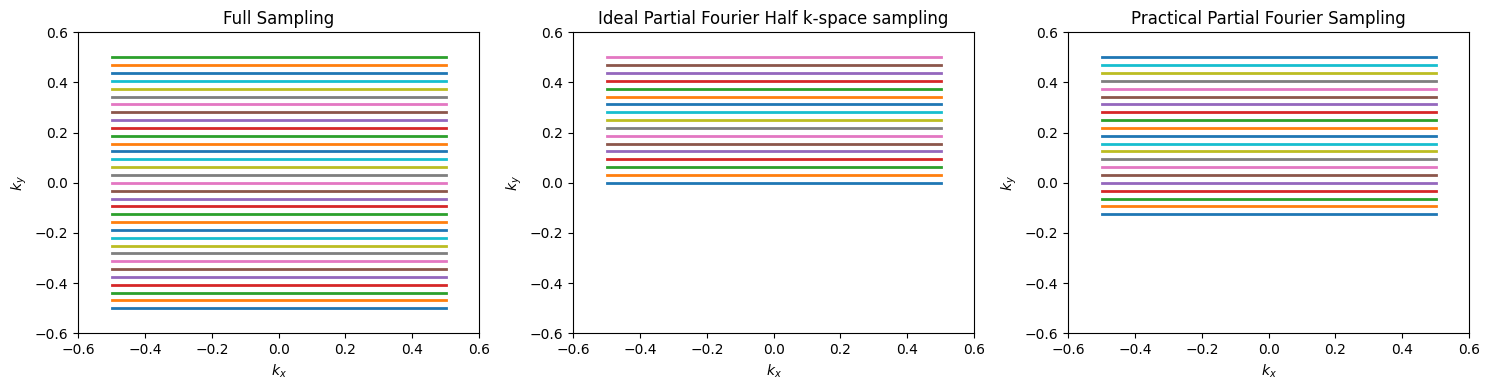

In [11]:
# Sample k-space sampling patterns for Partial Fourier Imaging

import numpy as np
import matplotlib.pyplot as plt

# Cartesian
N = 32
k = np.linspace(-N/2, N/2, N+1) / N
ky, kx = np.meshgrid(k, k)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Full Sampling
axes[0].plot(kx, ky, linewidth=2)
axes[0].set_xlim([-.6, .6])
axes[0].set_ylim([-.6, .6])
axes[0].set_xlabel('$k_x$')
axes[0].set_ylabel('$k_y$')
axes[0].set_title('Full Sampling')

# Ideal Partial Fourier Half k-space sampling
# Reshape to have one dimension of size N (here N+1 points exist, reshape accordingly)
mask = ky >= 0
kx_half = kx[mask].reshape(N + 1, -1)
ky_half = ky[mask].reshape(N + 1, -1)

axes[1].plot(kx_half, ky_half, linewidth=2)
axes[1].set_xlim([-.6, .6])
axes[1].set_ylim([-.6, .6])
axes[1].set_xlabel('$k_x$')
axes[1].set_ylabel('$k_y$')
axes[1].set_title('Ideal Partial Fourier Half k-space sampling')

# Practical Partial Fourier Sampling with over-sampling the center of k-space
pf_factor = 0.75 

mask_pf = ky >= -(pf_factor-0.5)/2
kx_pf = kx[mask_pf].reshape(N + 1, -1)
ky_pf = ky[mask_pf].reshape(N + 1, -1)

axes[2].plot(kx_pf, ky_pf, linewidth=2)
axes[2].set_xlim([-.6, .6])
axes[2].set_ylim([-.6, .6])
axes[2].set_xlabel('$k_x$')
axes[2].set_ylabel('$k_y$')
axes[2].set_title('Practical Partial Fourier Sampling')

plt.tight_layout()


## Parallel Imaging

Parallel Imaging uses the spatial information provided by individual RF receive coil elements to accelerate image acquisition.  With multiple RF receive coil elements, they can provide additional coarse scale localization information.  The primary parallel imaging approach is to undersample k-space by skipping phase encoding lines.  Another approach is to simultaneously excite and acquire multiple slices, known as simultaneous multi-slice (SMS) imaging. 


### Undersampled k-space Methods

In these approaches, phase encoding lines are skipped in k-sapce.  With direct Fourier Transform reconstruction, this results in aliasing artifacts due to violation of the sampling requirements.  Parallel imaging reconstruction methods use the spatial information from the multiple RF receive coil elements to resolve this aliasing.

All of these methods require incorporation of the coil sensitivity profiles, either through measurement, estimation, or incorporation into a model.  Coil sensitivity profiles can be measured with a coarse resolution (i.e. fast) pre-scan, and signal from the relatively uniform Body RF coil can be used as a reference to estimate the local receive coil element sensitivities.  This is incoporated into the popular "SENSE" method.  This approach will suffer from residual aliasing artifacts if there are mismatches between the measured coil sensitivities and the actual coil sensitivities during the accelerated scan, for example due to motion.

Methods that estimate or incorporate into the model the coil sensitivies typically require a fully sampled calibration region in the center of k-space.  This increases the scan time, but are more robust since they estimate the coil sensitivities directly from the data being reconstructed.  This includes the popular "GRAPPA" method.

### Simultaenous Multi-Slice (SMS) Methods

Simultaneous Multi-Slice (SMS) methods, also known as multi-band imaging, excite and acquire multiple slices simultaneously, then using the coil sensitivity profiles in the reconstruction to separate the signal from each slice.  The RF excitation pulses must excite multiple slice locations, which naively is done by summing multiple frequency-shifted RF pulses, each corresponding to a different slice location.  In practice, more complex designs are used to mitigate peak power and improve robustness.  The resulting k-space data contains the superposition of the signals from the multiple slices.

![Simultaneous Multi-Slice Illustration](images/parallel_imaging-simultaneous_multislice.png)

These methods also often use specialized RF phase modulation schemes, such as CAIPIRINHA, to improve the conditioning of the reconstruction problem by shifting the simultaneously excited slices in the phase encoding direction.

### SNR in Parallel Imaging

There is an SNR penalty when using these methods that varies in severity depending on the conditioning of the undersampled reconstruction matrix.  Variation in RF coil element sensitivity profiles in the direction of the undersampling leads to a more well-conditioned reconstruction and lower SNR penalty.  Conversely, less RF coil element sensitivity profile variation in the direction of the undersampling leads to a more ill-conditioned reconstruction matrix and higher SNR penatly.  Also, regions will little difference betweeen RF coils (typically in the center of the body), also tend to have larger SNR penalties.

This is characterized by the geometry factor, or "g-factor", where $g(\vec{r}) \geq 1$ characterizes a spatially-varying SNR loss that is dependent on the coil loading and geometry, k-space sampling pattern, and parallel imaging reconstruction method.  When appyling an acceleration factor of $R$, the total readout time reduces the SNR by $\sqrt{R}$ as well, leading to the SNR relationship:

$$SNR_{PI} = \frac{SNR_{full}}{g(\vec{r})\sqrt{R}}$$

### Artifacts with Parallel Imaging

Parallel Imaging artifacts typically appear as aliasing.  The undersampled data will have aliasing when not using a parallel imaging reconstruction method, and sometimes the aliasing is not completely removed.  There are also aliasing like artifacts when there is a mismatch between the data and measured coil sensitivity profiles.

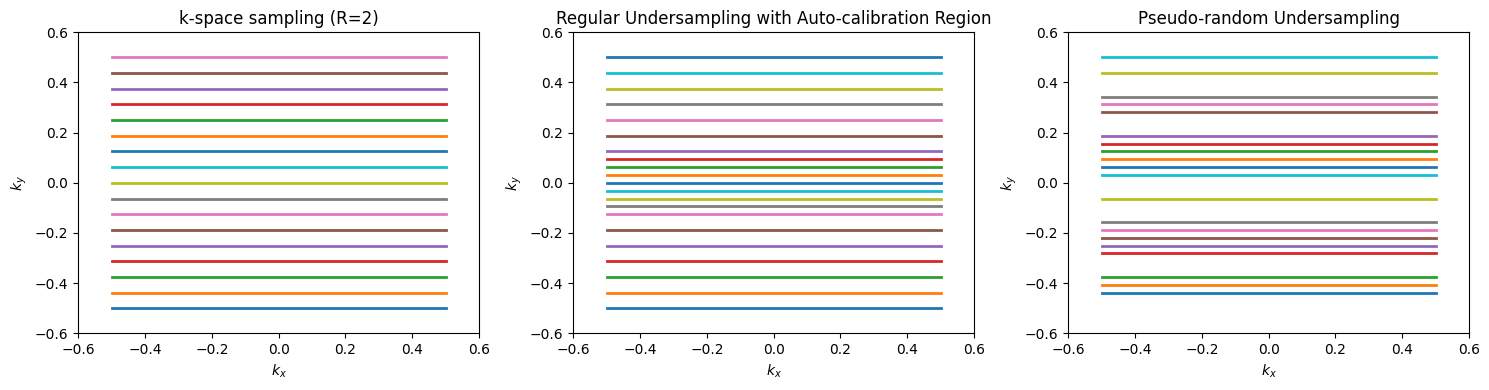

In [17]:
# Sample k-space sampling patterns for parallel imaging and compressed sensing

import numpy as np
import matplotlib.pyplot as plt

# Cartesian
N = 32
k = np.linspace(-N/2, N/2, N+1) / N
ky, kx = np.meshgrid(k, k)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Regular undersampling pattern
R = 2  # Acceleration factor
mask = (np.arange(N + 1) % R) == 0  # undersample only along ky (row) dimension
kx_regular = kx[:,mask]            # keep all kx samples for selected ky lines
ky_regular = ky[:,mask]

axes[0].plot(kx_regular, ky_regular, linewidth=2)
axes[0].set_xlim([-.6, .6])
axes[0].set_ylim([-.6, .6])
axes[0].set_xlabel('$k_x$')
axes[0].set_ylabel('$k_y$')
axes[0].set_title('k-space sampling (R=2)')

# Regular undersampling, with autocalibration region
acs_size = 8  # Size of autocalibration region
mask_acs = ((np.arange(N + 1) % R) == 0) | (np.abs(ky) < (acs_size / (N + 1) / 2))

kx_acs = kx[mask_acs].reshape(N + 1, -1)
ky_acs = ky[mask_acs].reshape(N + 1, -1)

axes[1].plot(kx_acs, ky_acs, linewidth=2)
axes[1].set_xlim([-.6, .6])
axes[1].set_ylim([-.6, .6])
axes[1].set_xlabel('$k_x$')
axes[1].set_ylabel('$k_y$')
axes[1].set_title('Regular Undersampling with Auto-calibration Region')

# Pseudo-random undersampling
mask_random = np.random.rand(N + 1) < (1 / R)
kx_random = kx[:,mask_random]
ky_random = ky[:,mask_random]

axes[2].plot(kx_random, ky_random, linewidth=2)
axes[2].set_xlim([-.6, .6])
axes[2].set_ylim([-.6, .6])
axes[2].set_xlabel('$k_x$')
axes[2].set_ylabel('$k_y$')
axes[2].set_title('Pseudo-random Undersampling')

plt.tight_layout()


## Compressed Sensing Methods

Compressed Sensing (CS) theory says that an image that is compressible in some domain can then be reconstructed from a subset of data samples.  MRI images are in fact compressible, so we can further accelerate our data acquisition with CS.  

Compressed Sensing for MRI is achieved by using k-space sampling patterns with pseudo-random undersampling, which is illustratid by the diagram below of the undersampled reconstruction procedure.  This results in incoherent artifacts that appear noise-like, which can then be removed by constraining the reconstruction to a sparse solution in some transform domain.

![Compressed Sensing Illustration](images/compressed_sensing_concept.gif)

**Caption** (Figure from https://doi.org/10.1109/MSP.2007.914728 ):
Heuristic procedure for reconstruction from undersampled data. A sparse signal (a) is 8-fold undersampled in its 1-D k -space domain (b). Equispaced undersampling results in signal aliasing (d) preventing recovery. Pseudo-random undersampling results in incoherent interference (c). Some strong signal components stick above the interference level, are detected and recovered by thresholding (e) and (f). The interference of these components is computed (g) and subtracted (h), thus lowering the total interference level and enabling recovery of weaker components.

Popular sparsifying transforms include total variation (TV), total generalized variation (TGV), and wavelets, where MRI images are typically sparse.  The pseudo-random undersampling typically uses a variable density that preferentially has more samples near the center of k-space.

### SNR in Compressed Sensing

It is difficult to define SNR when using compressed sensing reconstruction methods, as they inherently perform some denoising when constraining the reconstruction based on sparsity.  The apparent SNR can also vary significantly depending on the choice of the regularization factor.

### Artifacts with Compressed Sensing

The most common artifacts from compressed sensing come from overfitting to the sparsity penalty.  This result in either an over-smoothed, unnatural appearance or, in the case of a wavelet sparsifying transform, blocking artifacts.

## Deep Learning Reconstructions

Deep learning (DL) based methods can be used to reconstructed undersampled k-space into image data from a subset of data samples as well.  Conceptually, these methods can learn how to incorporate coil sensitivity information like parallel imaging and typical image sparsity patterns like compressed sensing.  Since they learn from real-world data, they can learn information that is the most relevant to MRI data and thus have been shown to support higher acceleration factors.  For example, they can learn what patterns within the image and/or k-space domain and most relevant and most common in MRI.

These methods require learning from large amounts (e.g. thousands or more) of training data samples, including fully-sampled MRI data as the ground truth. Fortunately, efforts such as the [fastMRI project](http://fastmri.med.nyu.edu) have provided large, high-quality datasets for training and evaluating these methods.

So-called un-rolled networks have become more popular for MRI reconstruction, as they can better incorporate parallel imaging information, data consistency, and learning common patterns in the data.  They are designed to mimic iterations of classical algorithms to solve optimization problems, and each iteration has been "un-rolled" into a series of cascaded neural networks.  Some popular methods include MoDL and Variational Networks.  

![Variational Network for MRI Reconstruction](images/end-to-end_varnet.jpg)

Caption (from https://arxiv.org/abs/2004.06688):
The E2E-VN model takes under-sampled k-space as input and applies several cascades, followed by IFT and RSS. Bottom: The DC module brings intermediate k-space closer to measured values, the Refinement module maps multi-coil k-space to one image, applies a U-Net and maps back to k-space, and the SME estimates sensitivity maps used in the refinement step.


### SNR in DL Reconstructions
It is difficult to define SNR when using machine learning reconstruction methods, as they inherently perform some denoising when constraining the reconstruction.


### Artifacts with DL Reconstructions

A challenge with machine learning reconstructions is that artifacts can be difficult to identify.  They can result in an over-smoothed appearance, but often a well-trained network will retain realistic texture and noise appearance features.  These methods can also overfit to the learned anatomy and data, meaning features might be erased or hallucinated, although using physics-based techniques provide some assurances of data-consistency.
